In [1]:
%pip install scikit-image --quiet
%pip install numpy --quiet
%pip install matplotlib --quiet
%pip install scipy --quiet
%pip install opencv-python --quiet
%pip install opencv-python-headless --quiet
%pip install opencv-contrib-python --quiet
%pip install scikit-learn --quiet
%pip install seaborn --quiet

]4;0;#000000\]4;1;#FFFFFF\]4;2;#CCCCCC\]4;3;#8f8f8f\]4;4;#FFFFFF\]4;5;#111111\]4;6;#CCCCCC\]4;7;#FFFFFF\]4;8;#404040\]4;9;#CCCCCC\]4;10;#FFFFFF\]4;11;#909090\]4;12;#CCCCCC\]4;13;#808080\]4;14;#CCCCCC\]4;15;#FFFFFF\]10;#FFFFFF\]11;[100]#000000\]12;#FFFFFF\]13;#FFFFFF\]17;#FFFFFF\]19;#000000\]4;232;#FFFFFF\]4;256;#FFFFFF\]708;[100]#000000\
Note: you may need to restart the kernel to use updated packages.
]4;0;#000000\]4;1;#FFFFFF\]4;2;#CCCCCC\]4;3;#8f8f8f\]4;4;#FFFFFF\]4;5;#111111\]4;6;#CCCCCC\]4;7;#FFFFFF\]4;8;#404040\]4;9;#CCCCCC\]4;10;#FFFFFF\]4;11;#909090\]4;12;#CCCCCC\]4;13;#808080\]4;14;#CCCCCC\]4;15;#FFFFFF\]10;#FFFFFF\]11;[100]#000000\]12;#FFFFFF\]13;#FFFFFF\]17;#FFFFFF\]19;#000000\]4;232;#FFFFFF\]4;256;#FFFFFF\]708;[100]#000000\
Note: you may need to restart the kernel to use updated packages.
]4;0;#000000\]4;1;#FFFFFF\]4;2;#CCCCCC\]4;3;#8f8f8f\]4;4;#FFFFFF\]4;5;#111111

In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage import io
from skimage import color
from skimage import filters

In [3]:
ORB_FEATURES = 1000
KNN = 7
ADD_ROTATION = True
ADD_FLIP = True
ADD_SCALE = True

In [4]:
data_train_dir = '../data/train'
data_test_dir = '../data/test'

# Load the images and keep the folder name as the label
def load_images(folder, n=None):
    images = []
    labels = []
    for label in os.listdir(folder):
        for filename in os.listdir(os.path.join(folder, label)):
            img = cv2.imread(os.path.join(folder, label, filename))
            if img is not None:
                images.append(img)
                labels.append(label)
            
            if n is not None and len(images) >= n:
                break
    return images, labels

images, labels = load_images(data_train_dir)
# test_images, test_labels = load_images(data_test_dir)
# # concat
# images = images + test_images
# labels = labels + test_labels

original_images = images.copy()

In [5]:
# add variations
def variations(img, label):
    result = [img]
    if ADD_ROTATION:
        for angle in [ cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_180, cv2.ROTATE_90_COUNTERCLOCKWISE]:
            # result.append(cv2.rotate(img, angle)) # makes weird results
            # result.append(cv2.warpAffine(img, cv2.getRotationMatrix2D((img.shape[1] / 2, img.shape[0] / 2), angle, 1.0), (img.shape[1], img.shape[0])) )
            result.append(cv2.rotate(img, angle))
        # add diagonal rotations
        for angle in [45, 135, 225, 315]:
            result.append(cv2.warpAffine(img, cv2.getRotationMatrix2D((img.shape[1] / 2, img.shape[0] / 2), angle, 1.0), (img.shape[1], img.shape[0])) )
    if ADD_FLIP:
        for flip in [ 1, -1]:
            result.append(cv2.flip(img, flip))
    if ADD_SCALE:
        for scale in [0.5, 1.5]:
            # scale and add border to keep the same size
            # result.append(cv2.resize(img, (0, 0), fx=scale, fy=scale))
            result.append(cv2.copyMakeBorder(cv2.resize(img, (0, 0), fx=scale, fy=scale), 0, 0, 0, 0, cv2.BORDER_REPLICATE))
            

    return result, [label] * len(result)

new_images = []
new_labels = []
for img, label in zip(images, labels):
    new_img, new_label = variations(img, label)
    new_images += new_img
    new_labels += new_label

images = new_images
labels = new_labels

print(f'Images: {len(images)}')
print(f'Labels: {len(labels)}')

Images: 864
Labels: 864


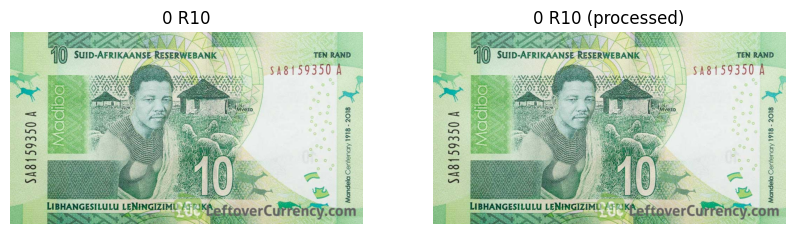

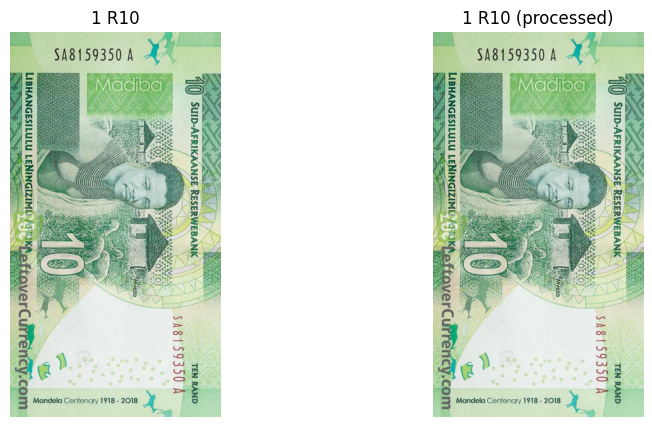

In [6]:
def display(images, original_images, l_labels,r_labels=None, display_images=[0]):
    if r_labels is None:
        r_labels = l_labels
    for i in display_images:
        f, axarr = plt.subplots(1, 2, figsize=(10, 5))
        axarr[0].imshow(cv2.cvtColor(original_images[i], cv2.COLOR_BGR2RGB))
        axarr[0].set_title(str(i) + ' ' + l_labels[i])
        axarr[0].axis('off')
        axarr[1].imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
        axarr[1].set_title(str(i) + ' ' + r_labels[i] + ' (processed)')
        axarr[1].axis('off')
        plt.show()
display(images, images, labels, labels, [0, 1])

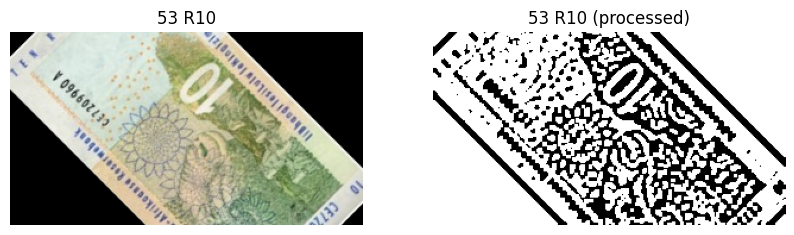

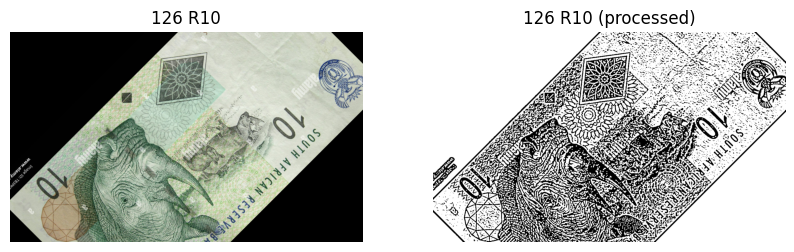

In [28]:
def preprocess(img):
    # enhance weight brighter colors
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    # img = cv2.split(img)[0]
    # img = cv2.equalizeHist(img)
    # img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    # img = cv2.resize(img, (224, 224))    
    
    # enhance white on black and black on white
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

    # enhance morphological operations
    kernel = np.ones((3,3),np.uint8)
    img = cv2.erode(img, kernel, iterations = 1)
    img = cv2.dilate(img, kernel, iterations = 1)

    
    
    return img

preprocessed_imgs = [preprocess(img) for img in images]
display(preprocessed_imgs, images, labels, display_images=[53, 126])

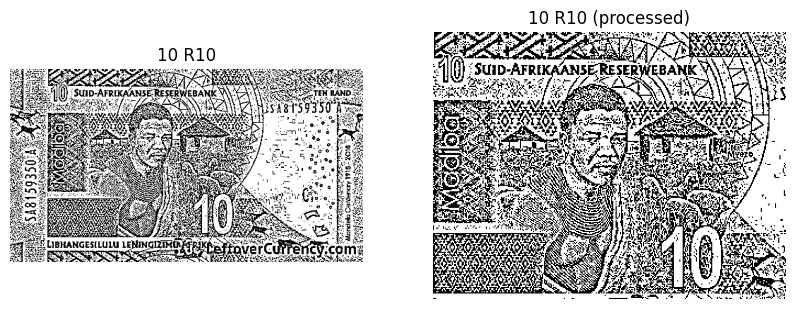

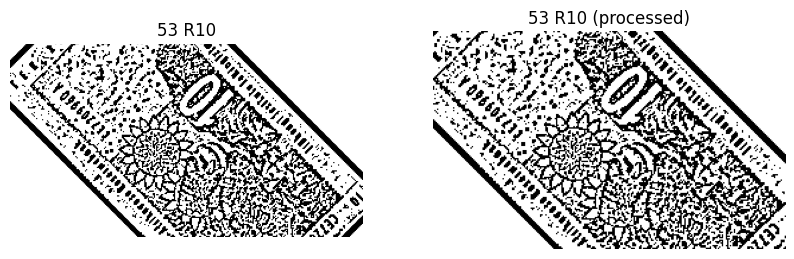

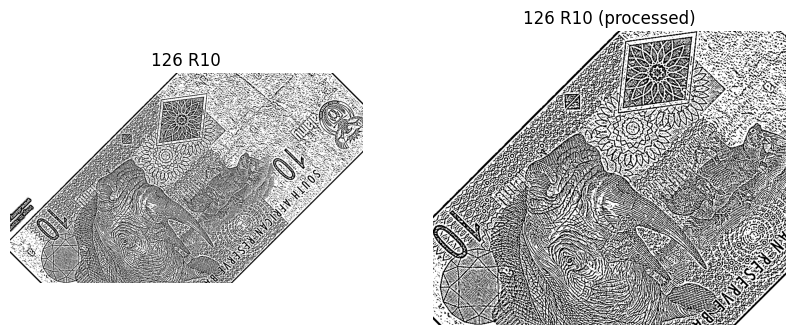

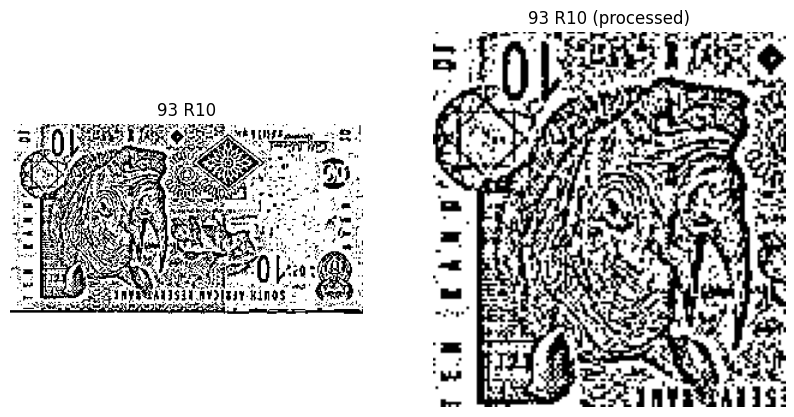

In [8]:
# align the images
def align_crop(img):
    # convert to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # threshold the image
    _, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # find the contours
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # find the largest contour
    max_area = 0
    max_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            max_contour = contour
    # find the bounding rectangle
    x, y, w, h = cv2.boundingRect(max_contour)
    # crop the image  into rect
    img = img[y:y+h, x:x+w]
    # crop into square
    # img = img[y:y+(h if h < w else w), x:x+(h if h < w else w)]
    return img


aligned_images = [align_crop(img) for img in preprocessed_imgs]
display(aligned_images,preprocessed_imgs,  labels, display_images=[10, 53, 126, 93], )

In [29]:
def extract_features(img):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    return keypoints, descriptors
    
keypoints, descriptors = zip(*[extract_features(img) for img in aligned_images])
print('Number of keypoints:', [len(k) for k in keypoints])
for i in range(len(descriptors)):
    if descriptors[i] is None:
        print(i)

print('Number of descriptors:',len(descriptors))
print('All shapes:', [d.shape for d in descriptors])

Number of keypoints: [8999, 9019, 8998, 9004, 4423, 6076, 4430, 6070, 9006, 8998, 1570, 20963, 10444, 10399, 10451, 10459, 9639, 10074, 9604, 10124, 10457, 10451, 2757, 29307, 69516, 69503, 69578, 69571, 56540, 55269, 56529, 55292, 69572, 69578, 7630, 195271, 3940, 3956, 3933, 3937, 1920, 1962, 1888, 1932, 3936, 3933, 1031, 11778, 1026, 1035, 1029, 1027, 1187, 1280, 1187, 1283, 1027, 1029, 182, 2307, 1075, 1087, 1090, 1085, 744, 634, 534, 443, 1085, 1090, 256, 1087, 1152, 1153, 1152, 1158, 1093, 921, 1101, 918, 1158, 1152, 282, 2815, 547, 543, 542, 558, 585, 322, 574, 323, 558, 542, 118, 1542, 875, 869, 868, 878, 776, 798, 773, 772, 878, 868, 177, 1774, 1209, 1214, 1218, 1218, 799, 803, 793, 811, 1218, 1218, 177, 3629, 18849, 18893, 18893, 18883, 17217, 18612, 17203, 18564, 18880, 18893, 3588, 65350, 601, 612, 600, 597, 569, 612, 565, 623, 597, 600, 146, 1939, 12866, 12864, 12865, 12865, 14154, 15579, 14176, 15617, 12865, 12865, 2925, 26980, 25950, 25960, 26004, 25956, 29668, 29294, 29

: 

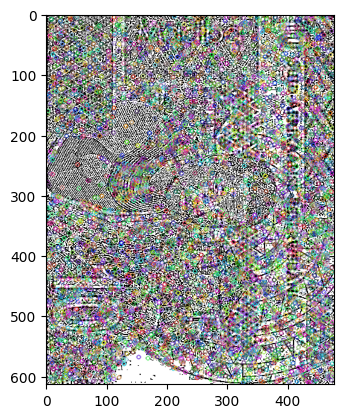

In [10]:
# display keypoints
def display_keypoints(img, keypoints):
    img = cv2.drawKeypoints(img, keypoints, img)
    plt.imshow(img)
    plt.show()

display_keypoints(aligned_images[53], keypoints[53])

In [11]:
all_descriptors = np.vstack(descriptors)
labels = np.array(labels)

all_descriptors.shape, labels.shape

((12103958, 128), (864,))

In [19]:
# clustering
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=1000, random_state=42)
kmeans.fit(all_descriptors)

MiniBatchKMeans(n_clusters=1000, random_state=42)

In [20]:
# bag of visual words
def bag_of_words(descriptors, kmeans):
    histogram = np.zeros(kmeans.n_clusters)
    if descriptors is not None:
        clusters = kmeans.predict(descriptors)
        for cluster in clusters:
            histogram[cluster] += 1
    return histogram

bovw = np.array([bag_of_words(d, kmeans) for d in descriptors])
bovw.shape

(864, 1000)

In [21]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# Standardize the features
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(bovw)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data_scaled, labels, test_size=0.2, random_state=42, stratify=labels)

# Initialize and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=KNN)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=1)

In [22]:
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Classification Accuracy: {accuracy * 100:.2f}%')

Classification Accuracy: 86.71%


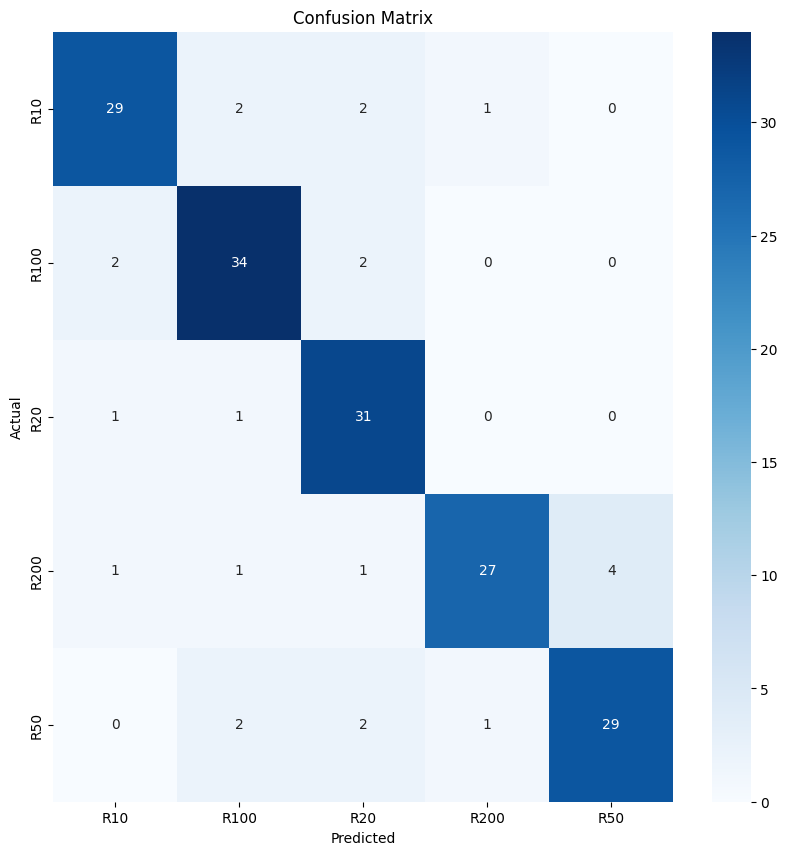

In [23]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


Test labels: ['R10', 'R10', 'R20', 'R20', 'R50', 'R50', 'R50', 'R100', 'R100', 'R200', 'R200', 'R200', 'R200', 'R200', 'R200']
Accuracy: 0.4


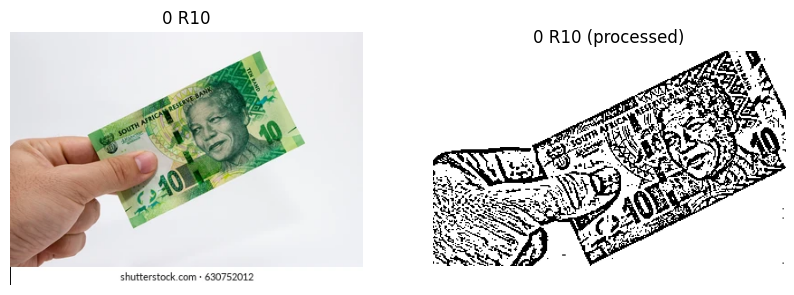

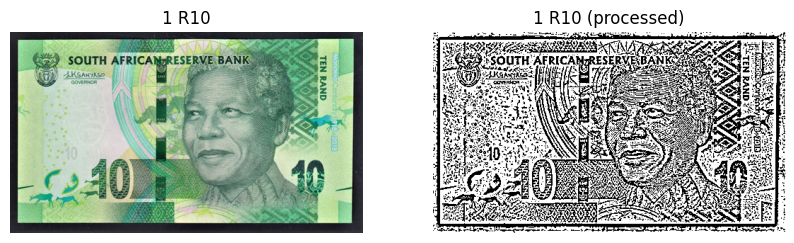

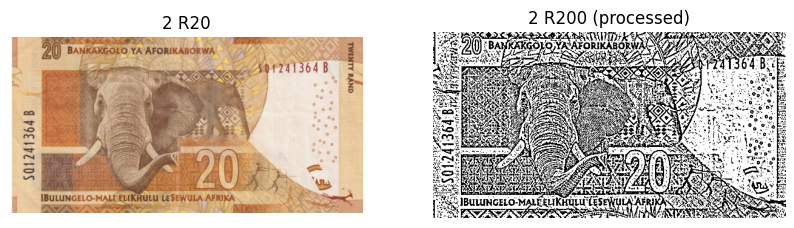

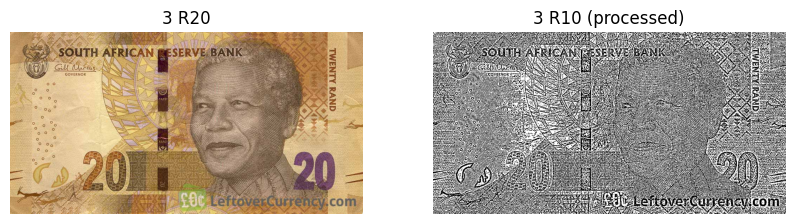

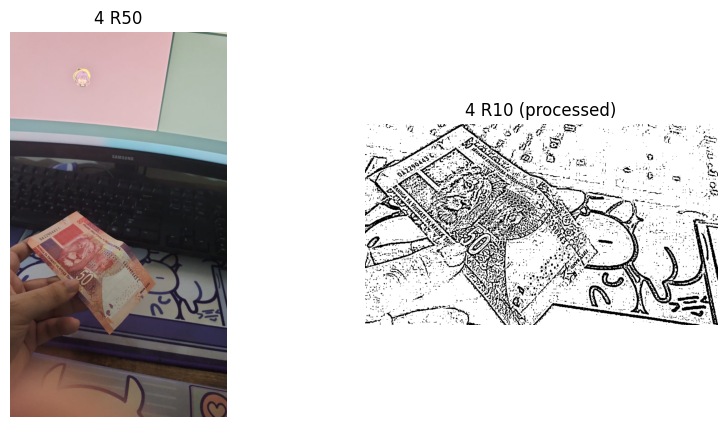

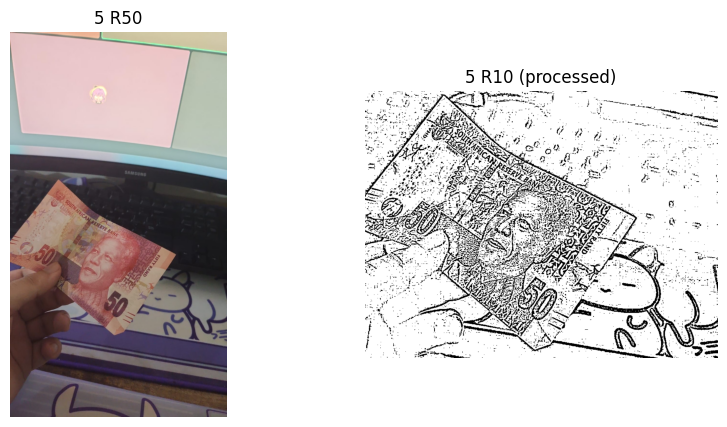

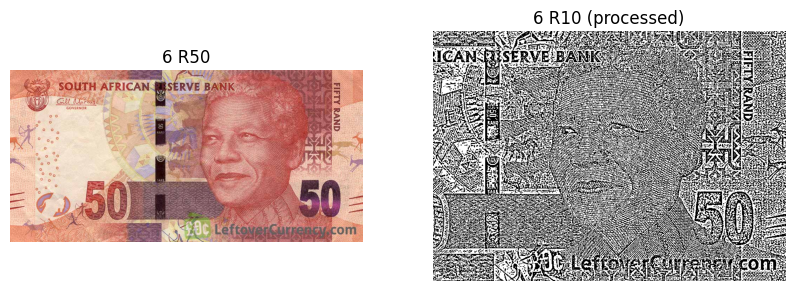

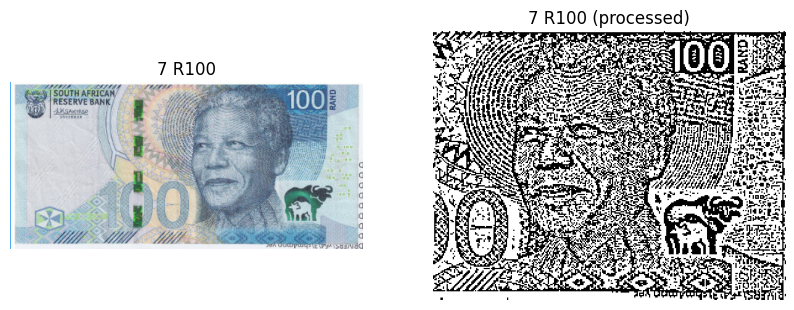

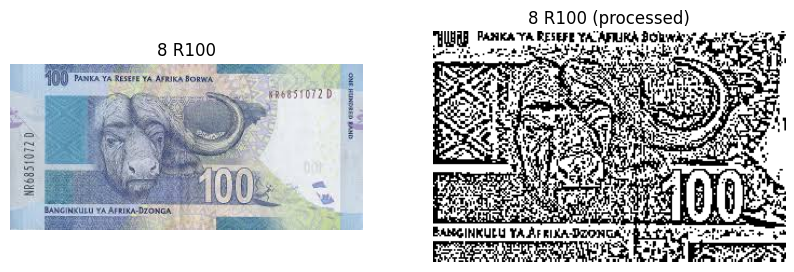

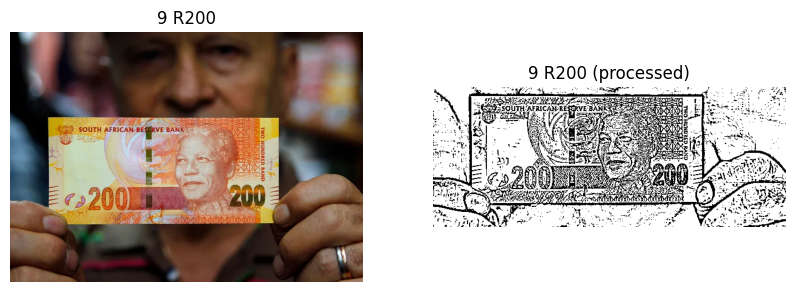

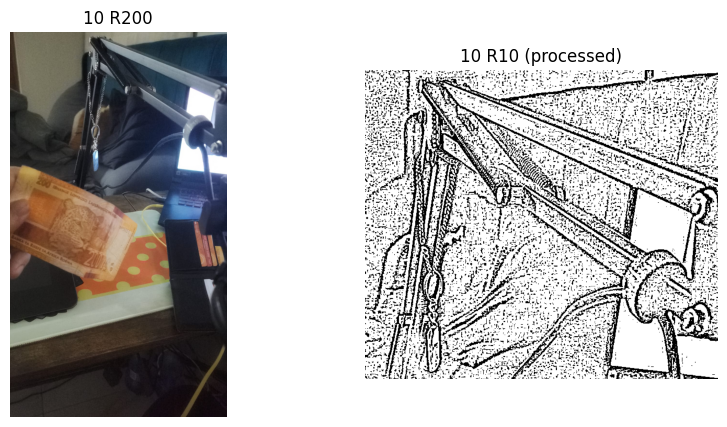

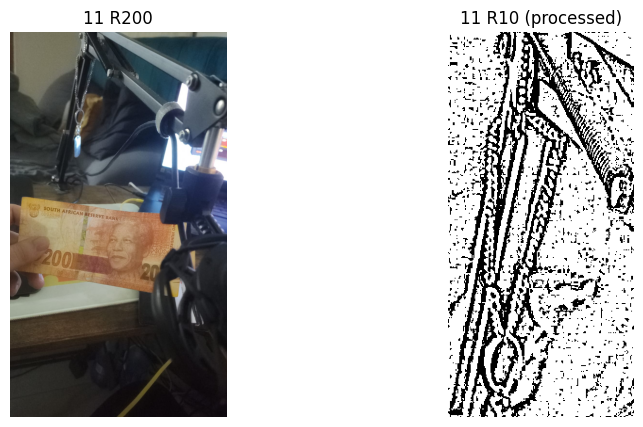

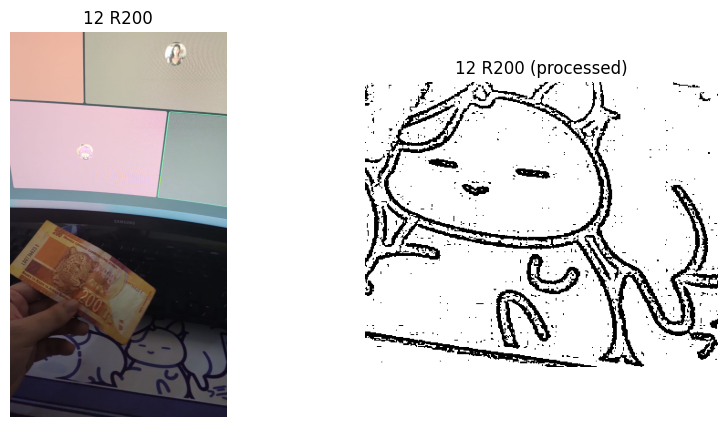

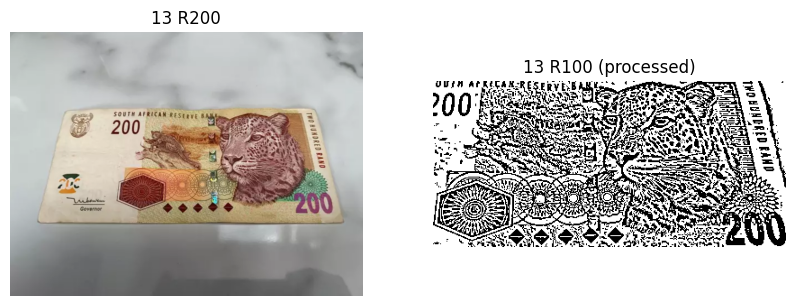

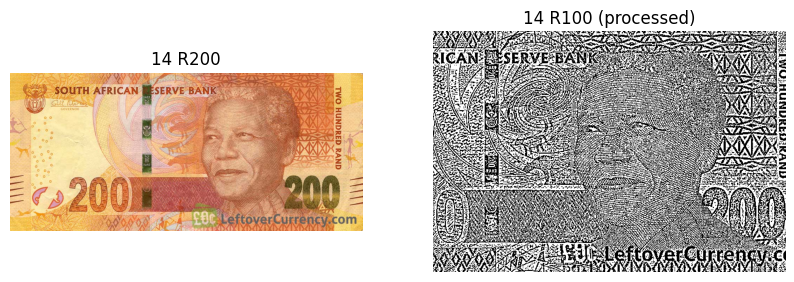

In [24]:
# some very specific examples that are difficult to classify
test_images, test_labels = load_images(data_test_dir)
print('Test labels:', test_labels)
original_test_images = test_images.copy()
test_images = [preprocess(img) for img in test_images]
test_images = [align_crop(img) for img in test_images]
test_descriptors = [extract_features(img)[1] for img in test_images]
test_bovw = np.array([bag_of_words(d, kmeans) for d in test_descriptors])
test_data_scaled = scaler.transform(test_bovw)
test_pred = knn.predict(test_data_scaled)
nums = [i for i in range(len(test_pred)) ]
print('Accuracy:', accuracy_score(test_labels, test_pred))
display(test_images, original_test_images, test_labels, test_pred, nums)